In [1]:
%%capture
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

We will generate most of the simulation configuration files based on parameters we feed into the simulation.

Warnings about RAM

Allow to have names in the node populations

Explanation about how node pop and commtuer network awas construced.

Explain what age groups we have

Mention that we set `min_num_moving` quite high here for demonstration purposes.

- Node populations
- Commuter network

- Generate contact matrices using formula
 - Note that the units of the contact matries are per hour, rather than day
 - 

- Contact matrices, different ones for school.
    - Note that the units of the contact matries are per hour, rather than day
- Write up nicely.
- Plot density dependence, with population also
- Make python version
- Make UK version
- Clean up rest of notebooks.
- Update config documentation
    - Can have NaNs in node parameters.
- Only compute necessary contact matrices at each node
    - Allow user to update this

# Generate the configuration files

### Define model

In [2]:
model = {
    "settings" : {
        "classes" : ["S", "E", "A", "I", "R"],
        "stochastic_threshold_from_below" : [1000, 1000, 1000, 1000, 1000],
        "stochastic_threshold_from_above" : [500, 500, 500, 500, 500],
        "infection_scaling" : "powerlaw",
        "infection_scaling_parameters" : [0, 0.004, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-betaI"], ["A", "-betaA"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["I", "betaI"], ["A", "betaA"] ]
    },

    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-gammaA"] ],
        "infection" : []
    },

    "I" : {
        "linear"    : [ ["A", "gammaA"], ["I", "-gammaI"] ],
        "infection" : []
    },

    "R" : {
        "linear"    : [ ["I", "gammaI"] ],
        "infection" : []
    }
}

model_classes = model['settings']['classes']
model_dim = len(model_classes)

### Configuration generation parameters

Here we define some parameters with which all the configuration files will be generated. Edit these if you want to change the simulation.

In [3]:
sim_config_path = 'london_simulation'

min_num_moving = 20 # Remove all commuting edges where less than `min_num_moving` are moving

# Decide which classes are allowed to commute
allow_class = [
    ('S', True),
    ('E', True),
    ('A', True),
    ('Ia1', True),
    ('Ia2', True),
    ('Ia3', True),
    ('Is1', True),
    ('Is2', False),
    ('Is3', False),
    ('R', True),
]

# Decide where to seed with infecteds
seed_pop = [
    (0, 1, 'E', 100),      # Home, age group, model class, seed quantity
    (10, 2, 'E', 100),      
    (23, 0, 'E', 100),     
    (622, 4, 'E', 100),
    (232, 4, 'E', 100)
]

# Node parameters

n_betaI = 0.02
n_betaA = 0.02
n_gammaE = 1/3.0
n_gammaA = 1/3.0
n_gammaI = 1/3.0

# Cnode parameters

cn_betaI = n_betaI
cn_betaA = n_betaA
cn_gammaE = n_gammaE
cn_gammaA = n_gammaA
cn_gammaI = n_gammaI

# Time steps

t_start = 0
t_end = 24*60*100

_, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  1*60),
    (7*60,  2),
    (10*60, 2*60),
    (17*60, 2),
    (19*60, 2*60)
], end_time=24*60)

### Format the commuting network

In [4]:
cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path)

#### Set which classes are allowed to commute

# Drop the current allow_O columns
cn = cn.iloc[:,:10]

# Set allow settings
for O, allow_O in allow_class:
    cn[ "Allow %s" % O ] = 1 if allow_O else 0
    
# Allow people to return home
cn.loc[ cn['Home'] == cn['To'],"Allow %s" % allow_class[0][0]:] = 1

#### Remove commuting edges where fewer than `min_num_moving` people are commuting

delete_rows = []

for i, row in cn.loc[ cn['Home'] == cn['From'] ].iterrows():
    if row['# to move'] < min_num_moving:
        delete_rows.append(i)
        delete_rows.append(i+1) # Delete the returning commuting edge as well

cn = cn.reset_index()
cn = cn.drop(delete_rows)
cn = cn.drop(columns='index')

cn.loc[cn['ct1'] == cn['ct2'], 'ct2'] += 0.1

cn.head()

,Home,From,To,Age,# to move,% to move,t1,t2,ct1,ct2,Allow S,Allow E,Allow A,Allow Ia1,Allow Ia2,Allow Ia3,Allow Is1,Allow Is2,Allow Is3,Allow R
22,0,0,186,5,26,-1,8.968254,9.000000,9.000000,9.166667,1,1,1,1,1,1,1,0,0,1
23,0,186,0,5,-1,1,17.000000,17.031746,17.031746,17.198413,1,1,1,1,1,1,1,1,1,1
28,0,0,187,4,33,-1,8.976399,9.000000,9.000000,9.166667,1,1,1,1,1,1,1,0,0,1
29,0,187,0,4,-1,1,17.000000,17.023601,17.023601,17.190268,1,1,1,1,1,1,1,1,1,1
30,0,0,187,5,49,-1,8.976399,9.000000,9.000000,9.166667,1,1,1,1,1,1,1,0,0,1


### Populate the network

Our `node_populations.csv` currently only has the total population for each age group at each node. In order to use it for the simulation, we must populate it with the model classes, as well as seed some infections.

In [5]:
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
tot_pop.head()

,Home,Location,N(0-4),N(5-10),N(11-15),N(16-24),N(25-34),N(35-49),N(50-64),N(65-74),N(75+)
0,0,0,414,601,250,910,1333,1624,1695,839,654
1,1,1,636,904,436,765,1057,1476,1036,432,550
2,2,2,845,1067,503,1094,1734,2261,1713,662,585
3,3,3,441,534,265,796,930,1113,1145,432,566
4,4,4,934,1189,562,1078,1517,2116,1404,485,397


In [6]:
# Create all model classes, and set everyone to be susceptible

npop = pd.DataFrame()
npop['Home'] = tot_pop['Home']
npop['Location'] = tot_pop['Location']

for _cn, _cd in tot_pop.iloc[:,2:].iteritems():
    for O in model['settings']['classes']:
        npop["%s%s" % (O, _cn[1:])] = 0
        
    npop["%s%s" % ("S", _cn[1:])] = _cd
    
# Seed with infecteds

for home, age, O, seed_quantity in seed_pop:
    row_i = npop[npop['Home'] == home].index[0]
    col_i = 2 + age*model_dim
    S = npop.iloc[row_i,col_i]
    npop.iloc[row_i, col_i + model_classes.index('E')] = seed_quantity
    npop.iloc[row_i, col_i] -= seed_quantity

### Setting the node and cnode parameters

We need to add rows giving the model parameters in `node_parameters.csv` and `cnode_parameters.csv`, which currently only has the areas of each geographical node:

In [7]:
nparam = pd.read_csv('london_simulation/node_parameters.csv')
cnparam = pd.read_csv('london_simulation/cnode_parameters.csv')
nparam.head()

,Home,Location,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
0,0,0,ALL,2.905399,NaN,NaN,NaN,NaN,NaN
1,1,1,ALL,2.165634,NaN,NaN,NaN,NaN,NaN
2,2,2,ALL,2.143565,NaN,NaN,NaN,NaN,NaN
3,3,3,ALL,2.490215,NaN,NaN,NaN,NaN,NaN
4,4,4,ALL,1.186180,NaN,NaN,NaN,NaN,NaN


In [8]:
cnparam['betaI'] = cn_betaI
cnparam['betaA'] = cn_betaA
cnparam['gammaE'] = cn_gammaE
cnparam['gammaA'] = cn_gammaA
cnparam['gammaI'] = cn_gammaI

nparam = nparam.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'Age' : 'ALL',
    'betaI' : n_betaI,
    'betaA' : n_betaA,
    'gammaE' : n_gammaE,
    'gammaA' : n_gammaA,
    'gammaI' : n_gammaI,
}, ignore_index=True)

nparam.iloc[-2:-1,:]

,Home,Location,Age,Area,betaI,betaA,gammaE,gammaA,gammaI
982,982,982,ALL,1.986049,NaN,NaN,NaN,NaN,NaN


### Contact matrices

Define the contact matrices

In [9]:
C_home = np.array( [
    [5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28,4.23],
    [4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28],
    [4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33],
    [4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4],
    [4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48],
    [4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58],
    [4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69],
    [4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83],
    [4.23,4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0],
] )
    
C_school = np.array( [
    [8.0,7.83,7.69,0.25,0.19,0.15,0.12,0.1,0.09],
    [7.83,8.0,7.83,0.26,0.19,0.15,0.12,0.1,0.09],
    [7.69,7.83,8.0,0.26,0.19,0.15,0.12,0.11,0.09],
    [0.25,0.26,0.26,0.27,0.2,0.15,0.13,0.11,0.09],
    [0.19,0.19,0.19,0.2,0.2,0.16,0.13,0.11,0.09],
    [0.15,0.15,0.15,0.15,0.16,0.16,0.13,0.11,0.09],
    [0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.11,0.1],
    [0.1,0.1,0.11,0.11,0.11,0.11,0.11,0.11,0.1],
    [0.09,0.09,0.09,0.09,0.09,0.09,0.1,0.1,0.1]
])

C_work = np.array( [
    [0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07],
    [0.07,0.09,0.08,0.08,0.08,0.08,0.08,0.08,0.08],
    [0.07,0.08,0.1,0.1,0.09,0.09,0.09,0.09,0.09],
    [0.07,0.08,0.1,0.12,0.12,0.11,0.11,0.11,0.11],
    [0.07,0.08,0.09,0.12,0.15,0.15,0.14,0.14,0.14],
    [0.07,0.08,0.09,0.11,0.15,0.2,0.19,0.19,0.19],
    [0.07,0.08,0.09,0.11,0.14,0.19,6.0,5.83,5.69],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.83,6.0,5.83],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.69,5.83,6.0]
])

C_transport = np.array( [
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0]
])

contact_matrices = {
    'C' : C_home + C_school + C_work,
    'C_commute' : C_transport
}

In [10]:
ncm = pd.DataFrame(columns=['Home', 'Location'] + model['settings']['classes'])

ncm = ncm.append({
    'Home' : 'ALL',
    'Location' : 'ALL',
    'A' : 'C',
    'I' : 'C'
}, ignore_index=True)

In [11]:
cncm = pd.DataFrame(columns=['Home', 'From', 'To'] + model['settings']['classes'])

cncm = cncm.append({
    'Home' : 'ALL',
    'From' : 'ALL',
    'To' : 'ALL',
    'A' : 'C_commute',
    'I' : 'C_commute'
}, ignore_index=True)

## Run simulation

In [12]:
sim = pyrossgeo.Simulation()

X_state = sim.initialize(
    model_dat = model,
    commuter_networks_dat = cn,
    node_populations_dat = npop,
    node_parameters_dat = nparam,
    cnode_parameters_dat = cnparam,
    contact_matrices_dat = contact_matrices,
    node_cmatrices_dat = ncm,
    cnode_cmatrices_dat = cncm
)

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=len(dts), steps_per_print=len(dts))

ts, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data)

ts_days = ts / (24*60)
ts_hours = ts / 60

Step 0 out of 16400
Step 164 out of 16400
Step 328 out of 16400
Step 492 out of 16400
Step 656 out of 16400
Step 820 out of 16400
Step 984 out of 16400
Step 1148 out of 16400
Step 1312 out of 16400
Step 1476 out of 16400
Step 1640 out of 16400
Step 1804 out of 16400
Step 1968 out of 16400
Step 2132 out of 16400
Step 2296 out of 16400
Step 2460 out of 16400
Step 2624 out of 16400
Step 2788 out of 16400
Step 2952 out of 16400
Step 3116 out of 16400
Step 3280 out of 16400
Step 3444 out of 16400
Step 3608 out of 16400
Step 3772 out of 16400
Step 3936 out of 16400
Step 4100 out of 16400
Step 4264 out of 16400
Step 4428 out of 16400
Step 4592 out of 16400
Step 4756 out of 16400
Step 4920 out of 16400
Step 5084 out of 16400
Step 5248 out of 16400
Step 5412 out of 16400
Step 5576 out of 16400
Step 5740 out of 16400
Step 5904 out of 16400
Step 6068 out of 16400
Step 6232 out of 16400
Step 6396 out of 16400
Step 6560 out of 16400
Step 6724 out of 16400
Step 6888 out of 16400
Step 7052 out of 164

## Plot the result

Plot the evolution of the whole network

Text(0.5, 0, 'Days')

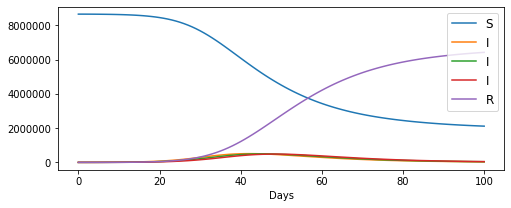

In [13]:
plt.figure( figsize=(8,3) )

S = np.sum(network_data[:,:,0], axis=1)
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E, label="I")
plt.plot(ts_days, A, label="I")
plt.plot(ts_days, I, label="I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Days')

### Plotting the result using GeoPandas

Assemble geo data and define helper functions. Edit `plot_frame` to change the format of the video.

In [14]:
import pickle
import tempfile
import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
from matplotlib import animation

# Simulation data

N_ = np.sum(location_data[:,:,:,:], axis=(1,2))

S_ = np.sum(location_data[:,:,0,:], axis=1)
E_ = np.sum(location_data[:,:,1,:], axis=1)
A_ = np.sum(location_data[:,:,2,:], axis=1)
I_ = np.sum(location_data[:,:,3,:], axis=1)
R_ = np.sum(location_data[:,:,4,:], axis=1)

s_ = S_ / N_
e_ = E_ / N_
a_ = A_ / N_
i_ = I_ / N_
r_ = R_ / N_

ts_days = pyrossgeo.utils.extract_ts(sim_data) / (24*60)

epi_data = np.sum(np.array([   # Used to plot pandemic curves
    S_,E_,A_,I_,R_
]), axis=2)

# Load geometry

geometry_node_key = 'msoa11cd'
geometry = gpd.read_file("../geodata/london_geo/london_msoa_shapes/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")

loc_table = pd.read_csv('london_simulation/loc_table.csv')
loc_table_loc_col = loc_table.columns[0]
loc_table_loc_key_col = loc_table.columns[1]

geometry = geometry[ geometry[geometry_node_key].isin(loc_table.iloc[:,1]) ] # Remove locations in geometry that are not in loc_table
geometry = geometry.merge(loc_table, left_on=geometry_node_key, right_on=loc_table_loc_key_col) # Add location indices
geometry = geometry.sort_values(by=loc_table_loc_col) # Sort them by location indices

# Edit this function to adjust the layout of the video

def plot_frame(ti, close_plot=False, tmp_save=None):
    fig, axes = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios':[1, 1, 1.3]}, figsize=(18, 14))

    geometry['S'] = s_[ti,:]
    geometry['E'] = e_[ti,:]
    geometry['A'] = a_[ti,:]
    geometry['I'] = i_[ti,:]
    geometry['R'] = r_[ti,:]
    
    plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='S', title="Susceptible", legend=False)
    plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='E', title="Exposed", legend=False)
    plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='A', title="Activated", legend=True)
    plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='I', title="Infected", legend=False)
    plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R', title="Recovered", legend=False)
    
    plot_epi(axes[1,2], ti, ts_days, epi_data, ['S','E','A','I','R'])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("SEAIR Model - Day %s" % ti, fontsize=18)
    
    if not tmp_save is None:
        plt.savefig(tmp_save.name + '/%s.png' % ti)
    if close_plot:
        plt.close(fig)
    if not tmp_save is None:
        return tmp_save.name + '/%s.png' % ti

# Helper functions for plotting

def plot_geo(geometry, ax, vmin, vmax, value_key='val', title="", legend=True, legend_label='', cax=None, axis_on=False):
    if legend:
        if cax is None:
            geometry.plot(column=value_key, ax=ax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
        else:
            geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
    else:
        geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=False)
        
    ax.set_title(title)
    if not axis_on:
        ax.set_axis_off()
        
def plot_epi(ax, ti, ts, epi_data, epi_data_labels):
    for oi in range(epi_data.shape[0]):
        ax.plot(ts[:ti], epi_data[oi,:ti], label=epi_data_labels[oi])
    ax.legend(loc='center left')
    
    ax.set_xlim(np.min(ts_days), np.max(ts_days))
    ax.set_ylim(0, np.max(epi_data))

Plot the pandemic at a given day

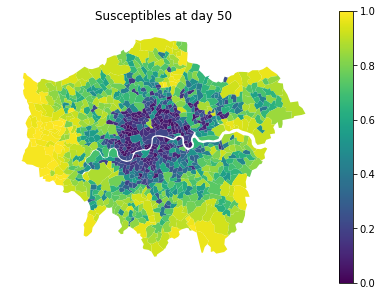

In [15]:
day = 50

geometry['S'] = s_[day,:]
geometry['E'] = e_[day,:]
geometry['A'] = a_[day,:]
geometry['I'] = i_[day,:]
geometry['R'] = r_[day,:]

fig, ax = plt.subplots(figsize=(7, 5))

plot_geo(geometry, ax, vmin=0, vmax=1, value_key='S', title='Susceptibles at day %s' % day)

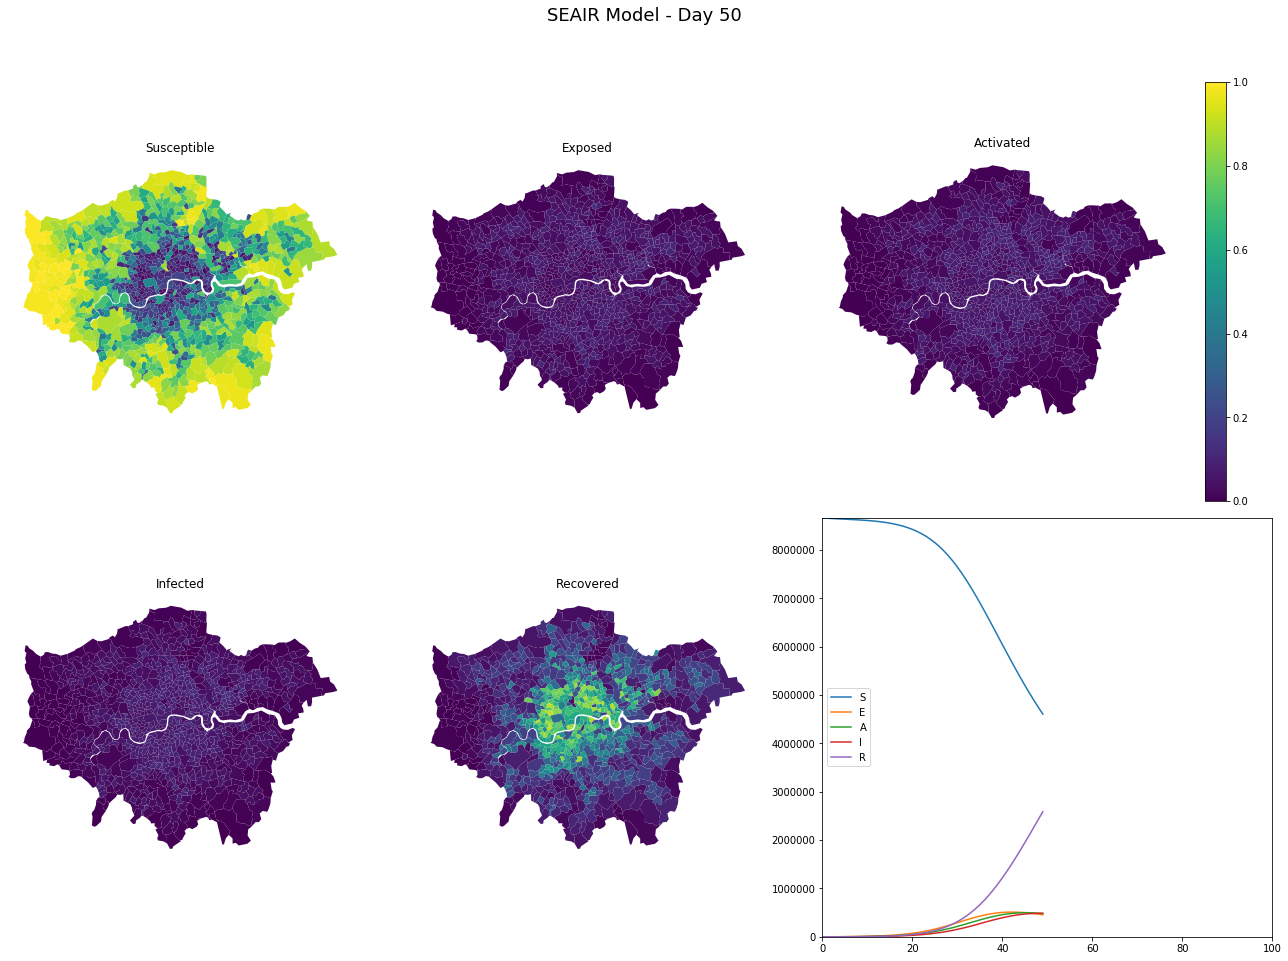

In [16]:
day = 50

plot_frame(day)

Create a video of the pandemic

In [17]:
tmp_dir = tempfile.TemporaryDirectory()

frames_paths = []

for ti in range(len(ts)):
    if ti % 1 == 0:
        print("Frame %s of %s" % (ti, len(ts)))
    frame_path = plot_frame(ti, close_plot=True, tmp_save=tmp_dir)
    frames_paths.append(frame_path)
    
import cv2

video_name = 'sim_video.mp4'

frame = cv2.imread(frames_paths[0])
height, width, layers = frame.shape
fps = 6
#codec=cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
codec=cv2.VideoWriter_fourcc(*'DIVX')

video = cv2.VideoWriter(video_name, codec, fps, (width,height))

for frame_path in frames_paths:
    video.write(cv2.imread(frame_path))

cv2.destroyAllWindows()
video.release()

Frame 0 of 101
Frame 1 of 101
Frame 2 of 101
Frame 3 of 101
Frame 4 of 101
Frame 5 of 101
Frame 6 of 101
Frame 7 of 101
Frame 8 of 101
Frame 9 of 101
Frame 10 of 101
Frame 11 of 101
Frame 12 of 101
Frame 13 of 101
Frame 14 of 101
Frame 15 of 101
Frame 16 of 101
Frame 17 of 101
Frame 18 of 101
Frame 19 of 101
Frame 20 of 101
Frame 21 of 101
Frame 22 of 101
Frame 23 of 101
Frame 24 of 101
Frame 25 of 101
Frame 26 of 101
Frame 27 of 101
Frame 28 of 101
Frame 29 of 101
Frame 30 of 101
Frame 31 of 101
Frame 32 of 101
Frame 33 of 101
Frame 34 of 101
Frame 35 of 101
Frame 36 of 101
Frame 37 of 101
Frame 38 of 101
Frame 39 of 101
Frame 40 of 101
Frame 41 of 101
Frame 42 of 101
Frame 43 of 101
Frame 44 of 101
Frame 45 of 101
Frame 46 of 101
Frame 47 of 101
Frame 48 of 101
Frame 49 of 101
Frame 50 of 101
Frame 51 of 101
Frame 52 of 101
Frame 53 of 101
Frame 54 of 101
Frame 55 of 101
Frame 56 of 101
Frame 57 of 101
Frame 58 of 101
Frame 59 of 101
Frame 60 of 101
Frame 61 of 101
Frame 62 of 101
Fr